In [28]:
import itertools
import dataclasses
import random
import tqdm.notebook

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import sklearn.cluster
import sklearn.mixture
import sklearn.model_selection
import sklearn.metrics
import sklearn.model_selection

In [2]:
RANDOM_SEED = 42

random.seed(RANDOM_SEED)

### Загрузка датасета

Для начала загрузим датасет. В этот раз воспользуемся библиотекой `pandas` и
представим датасет в виде `pandas.DataFrame`.

In [ ]:
dataset = pd.read_excel('datasets/lab2-04.xlsx')
dataset.head()

,0,1
0,-6.383976,0.831166
1,-6.676808,-2.087329
2,0.380398,1.726267
3,-5.974045,3.571401
4,-7.555926,3.254611


### Визуализация

Визуализируем датасет в виде диаграммы рассеяния. Аналогично прошлой лабораторной работе, воспользуемся для этого библиотекой `matplotlib`.

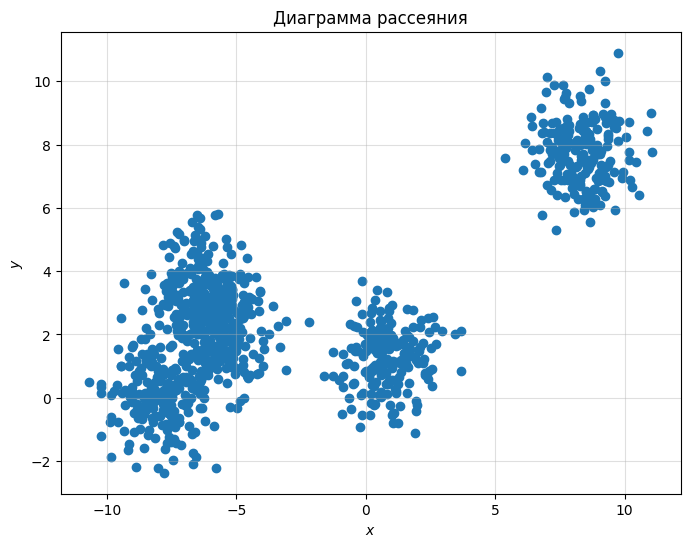

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(dataset[0], dataset[1])
plt.title('Диаграмма рассеяния')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True, alpha=0.4)
plt.show()

### Подготовка датасета

После того, как мы визуализировали датасет, с которым будем далее работать,
попробуем его проанализировать и извлечь полезную для дальнейшего обучения
информацию.

#### Количество кластеров

На основе оценки визуализации можно сделать вывод о том, что датасет
представляет из себя 3 кластера. При этом кластеры имеют эллипсоидную форму.

#### Разметка данных

Так как ранее мы сделали вывод о том, что кластеры в датасете имеют
эллипсоидную форму, то попробуем на основе разметить данные. Размеченные
данные нам помогут при дальнейшей оценке обученных моделей кластеризации.

Для этого опишем кластер в виде отдельного класса `Cluster`, который
будет содержать конфигурацию и логику по определению, принадлежат ли
переданные входные точки кластеры или нет.

In [5]:
@dataclasses.dataclass
class Cluster:
  center: tuple[float, float]
  size: tuple[float, float]

  def contains(self, points):
    cx, cy = self.center
    w, h = self.size

    x = (points[:, 0] - cx) / w
    y = (points[:, 1] - cy) / h

    return x ** 2 + y ** 2 <= 1.0

Далее, опишем функцию, которая создаст `numpy`, элементы которого
будут соответствовать уникальному номеру кластера. На вход такая функция
будет принимать набор кластеров и входные точки.

In [6]:
def split_on_clusters(clusters, points):
    cluster_ids = np.array([list(range(1, len(clusters) + 1))])
    contains_matrix = np.array([cluster.contains(points) for cluster in clusters])
    return (cluster_ids @ contains_matrix)[0]

И в конце опишем вспомогательную функцию, которая будет визуализировать
кластеры. На вход такая функция будет принимать массив двумерных точек
и массив с индексами кластеров. Для каждого из кластеров функция будет генерировать уникальный цвет.

In [7]:
def _get_color():
  return tuple(random.random() for _ in range(3))

def draw_clusters(points, cluster_ids):
  plt.figure(figsize=(8, 6))
  plt.title('Визуализация кластеров')
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  for cluster_id in set(cluster_ids):
    cluster_points = points[cluster_ids == cluster_id]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'cluster-{cluster_id}', color=_get_color())
  plt.legend()
  plt.grid(visible=True, alpha=0.4)
  plt.show()

Теперь, опишем 3 кластера через параметры эллипса и кластеризуем наш датасет.
В результате кластеризации добавим к датасету новый признак `cluster`. После
кластеризации визуализируем полученный датасет.

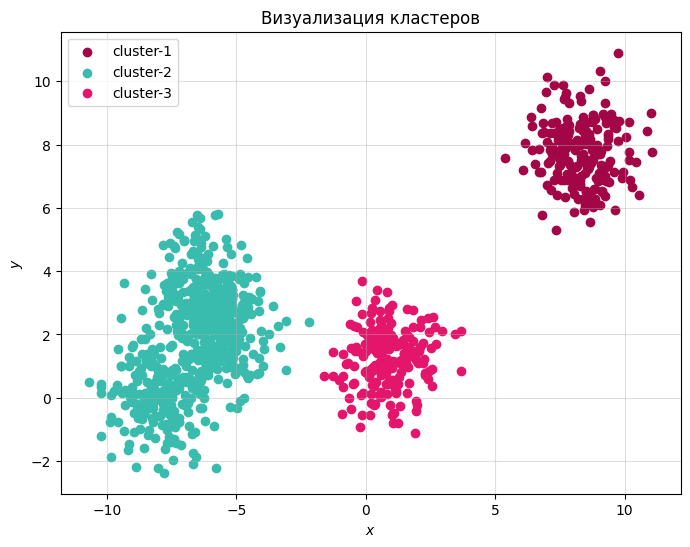

In [8]:
clusters = [
  Cluster(center=(8.0, 8.0), size=(3.5, 4)),
  Cluster(center=(-6.5, 1.0), size=(4.5, 5)),
  Cluster(center=(1.5, 1), size=(3.5, 4)),
]

points = dataset[[0, 1]].to_numpy()
cluster_ids = split_on_clusters(clusters, points)
draw_clusters(points, cluster_ids)

In [9]:
dataset['cluster'] = cluster_ids
dataset.head()

,0,1,cluster
0,-6.383976,0.831166,2
1,-6.676808,-2.087329,2
2,0.380398,1.726267,3
3,-5.974045,3.571401,2
4,-7.555926,3.254611,2


### Обучение моделей

Теперь, перейдем к обучению моделей для решения задачи
кластеризации.

#### Определение метрик

После обучения каждой из рассматриваемых далее моделей
у нас возникнет необходимость в оценке их качестве. Для
этой цели нам необходимо выбрать метрики, на основе которых
мы будем непосредственно оценивать качество.

При обучении модели использовались следующие метрики:

- **Коэффициент силуэта**. Эта метрика показывает, на сколько
  "хорошо" сгруппированы кластеры. Эта метрика определяется
  за счет среднего расстояния до всех точек одного кластера и
  среднего расстояние до точек другого кластера. Задача модели состоит в том, чтобы минимизировать внутрикластерное расстояние и максимизировать межкластерное.

- **Однородность**. Данная метрика подходит для нашего случая,
  так как мы провели предварительно разметку датасета. Она позволяет определить, не пытается ли модель соотнести в один
  кластер точки разных кластеров.

- **Полнота**. Данная метрика позволяет определить, не
  "разбрасывает" ли модель точки одногго кластера по разным.

- **V-мера**. Аналог **P-value** из задачи классификации.
  Является средним между однородностью и полнотой. Позволяет
  рассмотреть результаты обучения более полно.

Напишем для определения метрик вспомогательную функцию.

In [10]:
_METRICS = [
    {
        'key': 'silhouette_score',
        'formatted_key': 'Коэффициент силуэта',
        'metric': lambda X, y, y_pred: sklearn.metrics.silhouette_score(X, y_pred),
    },
    {
        'key': 'homogeneity_score',
        'formatted_key': 'Однородность',
        'metric': lambda X, y, y_pred: sklearn.metrics.homogeneity_score(y, y_pred),
    },
    {
        'key': 'completeness_score',
        'formatted_key': 'Полнота',
        'metric': lambda X, y, y_pred: sklearn.metrics.completeness_score(y, y_pred),
    },
    {
        'key': 'v_measure_score',
        'formatted_key': 'V-мера',
        'metric': lambda X, y, y_pred: sklearn.metrics.v_measure_score(y, y_pred),
    },
]


def calculate_metrics(X, y, y_pred, *, formatted=False):
  if formatted:
    return pd.DataFrame([
      {'Метрика': metric['formatted_key'], 'Значение': metric['metric'](X, y, y_pred)}
      for metric in _METRICS
    ])
  else:
    return {
      metric['key']: metric['metric'](X, y, y_pred)
      for metric in _METRICS
    }

#### Разделение на тестовую и обучающую

Для обучения и тестированния модели нам необходимо два разных
датасета. Для этого разделим датасет на обучающую и тестовую выборки. Разделение будет происходит в стандартном соотношении $80 \%$ на $20 \%$.

In [11]:
ds_train, ds_test = sklearn.model_selection.train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)

X_train, y_train = ds_train[[0, 1]].to_numpy(), ds_train['cluster'].to_numpy()
X_test, y_test = ds_test[[0, 1]].to_numpy(), ds_test['cluster'].to_numpy()

#### DBSCAN

Первой моделью, которую мы обучим, является DBSCAN. Эта модель не требует
знаний о количестве кластеров и подходит для кластеров произвольной формы.
Иными словами, она является общей моделью для решения задачи кластеризации.

Попробуем для начала установить значения гиперпараметров модели вручную
и проанализируем обученную таким образом модель.

In [13]:
X, y = dataset[[0, 1]].to_numpy(), dataset['cluster'].to_numpy()
model = sklearn.cluster.DBSCAN(eps=0.5, min_samples=3)
model.fit(X)

calculate_metrics(X, y, model.labels_, formatted=True)

,Метрика,Значение
0,Коэффициент силуэта,0.328624
1,Однородность,0.965448
2,Полнота,0.831252
3,V-мера,0.893338


Как видим, обученная модель далека от идеале. Значение коэффициента
силуэта равно `0.3`, что ближе к середине диапазона возможных значений
$[-1, 1]$. Провизуализируем кластеры, на которые модель разбила датасет.

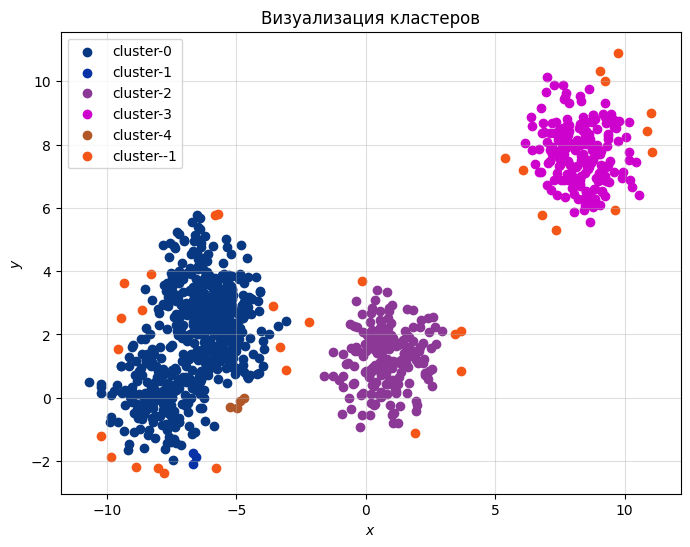

In [14]:
draw_clusters(X, model.labels_)

Как видим, модель оказалось очень чувствительной к выбросам и не отнесла их
ни к каким кластерам. Основные кластеры модель правильно распознала, необходим
тюнинг модели.

##### Улучшение бейзлайна

На основе прошлых выводов у нас возникла необходимость в улучшении бейзлайна
с целью получения более точной модели. Попробуем воспользоваться методом
подбора гиперпараметров. В качестве подбираемых гиперпараметров возьмем
`eps`, `min_samples` и `algorithm`.

При подборе гиперпараметров нам необходимо понять, какая конфигурация
для модели окажется лучшей. Оценку итогового качестве конфигурации
будет проводить на основе значений метрики коэффициента силуэта.

In [17]:
eps_range = np.linspace(0.1, 1.1, 10)
samples_range = range(3, 7, 1)
algorithm_range = {'auto', 'ball_tree', 'kd_tree', 'brute'}
hyper_params_range = tuple(
  itertools.product(
    eps_range,
    samples_range,
    algorithm_range,
  )
)

def learn_model(eps, min_samples, algorithm, X, y):
  model = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples, algorithm=algorithm)
  model.fit(X)
  metrics = calculate_metrics(X, y, model.labels_)
  return metrics['silhouette_score']

result = pd.DataFrame([
  {
    'eps': eps,
    'min_samples': min_samples,
    'algorithm': algorithm,
    'score': learn_model(eps, min_samples, algorithm, X, y)
  }
  for eps, min_samples, algorithm in tqdm.notebook.tqdm(hyper_params_range)
])

# Выводим конфигурации с наилучшим результатом
result[result['score'] == result['score'].max()]


  0%|          | 0/160 [00:00<?, ?it/s]

,eps,min_samples,algorithm,score
96,0.766667,3,ball_tree,0.697611
97,0.766667,3,brute,0.697611
98,0.766667,3,kd_tree,0.697611
99,0.766667,3,auto,0.697611
100,0.766667,4,ball_tree,0.697611
101,0.766667,4,brute,0.697611
102,0.766667,4,kd_tree,0.697611
103,0.766667,4,auto,0.697611


Как видим, одной из самых лучших конфигураций оказалась конфигурация
`eps=0.77`, `min_samples=3`, `algorithm=ball_tree`. Стоит отметить использование
алгоритма `ball_tree`, так как он основан на представлении множества
соседних точек в виде шарообразного множества, что отлично накладывается
на текущий датасет.

Увеличение значения для параметра `eps` связано с тем, что DBSCAN чувствителен
к масштабу значений. В прошлый раз мы взяли слишком маленькое значений `eps`,
из-за чего как раз и возникла проблема того, что DBSCAN брал небольшие
объединения точек в отдельные кластеры.

In [18]:
model = sklearn.cluster.DBSCAN(eps=0.77, min_samples=3, algorithm='ball_tree')
model.fit(X)
calculate_metrics(X, y, model.labels_, formatted=True)

,Метрика,Значение
0,Коэффициент силуэта,0.697611
1,Однородность,0.991788
2,Полнота,0.953505
3,V-мера,0.972270


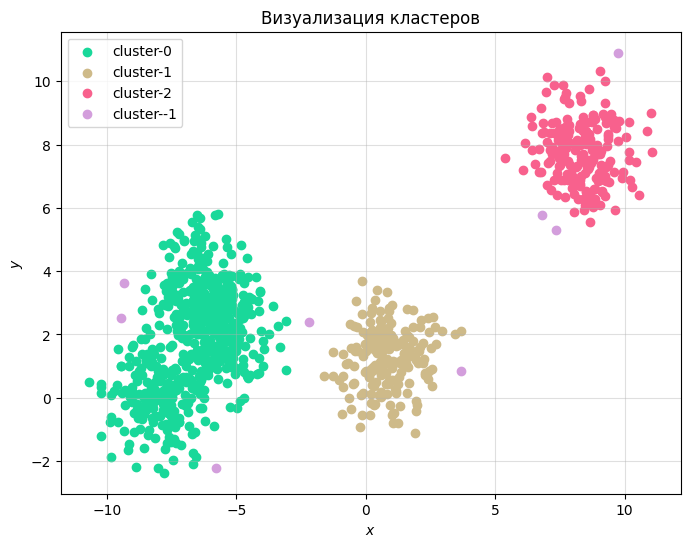

In [19]:
draw_clusters(X, model.labels_)

Как видим, модель стала справляться с поставленной задачей кластеризации
значительно лучше, однако результат все еще далек от идеала. Попробуем использовать другие модели для решения задачи кластеризации.

#### KMeans

Попробуем теперь взять модели, имеющие больше ограничений в отличие от DBSCAN
и предназначенные для более узкого спектра задач. Одной из такких моделей является `KMeans`, основанная на алгоритме K-средних.

Задача модели `KMeans` состоит в минимизации суммы квадратов расстояний
до центроидов. Текущий датасет отлично подходит для данной модели, так как
она особенно подходит в случаях, когда:
- Кластеры имеют выпуклую форму (в том числе и эллипсоидную)
- Количество кластеров известно
- Кластеры имеют одинаковую плотность, в чем мы можем убедиться по отсутствию
  "дыр" в визуализации кластеров датасета.

In [26]:
model = sklearn.cluster.KMeans(n_clusters=3, random_state=RANDOM_SEED, n_init="auto")
model.fit(X_train)
calculate_metrics(X_test, y_test, model.predict(X_test), formatted=True)

,Метрика,Значение
0,Коэффициент силуэта,0.708654
1,Однородность,1.000000
2,Полнота,1.000000
3,V-мера,1.000000


Как видим, модель показала "идеальные" результаты! V-мера, однородность и
полнота показываются пороговые значения `1`, что говорит нам о том, что
модель идеально распознает кластеры, в которых  находятся точки.

Проверим это визуально, провизуализировав то, как модель разбивает весь
датасет на кластеры.

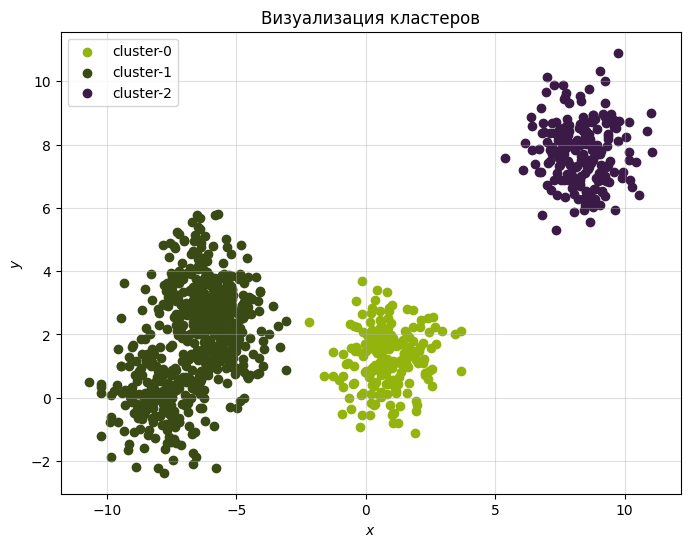

In [27]:
draw_clusters(X, model.predict(X))

#### GMM

В конце рассмотрим еще одну модель для решения задачи кластеризации - GMM.
Главная особенность GMM состоит в том, что она построена на основе
вероятностных распределений, в отличие от `KMeans`, который основан
на геометрических методах.

GMM отлично подходит для случаев, когда кластеры имеют эллипсоидную форму,
что как раз подходит для текущего датасета.


In [29]:
model = sklearn.mixture.GaussianMixture(
    n_components=3,
    covariance_type='spherical',
    random_state=RANDOM_SEED,
)
model.fit(X_train)
calculate_metrics(X_test, y_test, model.predict(X_test), formatted=True)

,Метрика,Значение
0,Коэффициент силуэта,0.708654
1,Однородность,1.000000
2,Полнота,1.000000
3,V-мера,1.000000


Как видим, результаты GMM ничем не отличаются от KMeans для текущего датасета.
Модель также показывает "идеальные" результаты! Убедимся в этом, провизуализировав то, как модель кластеризует весь датасет.

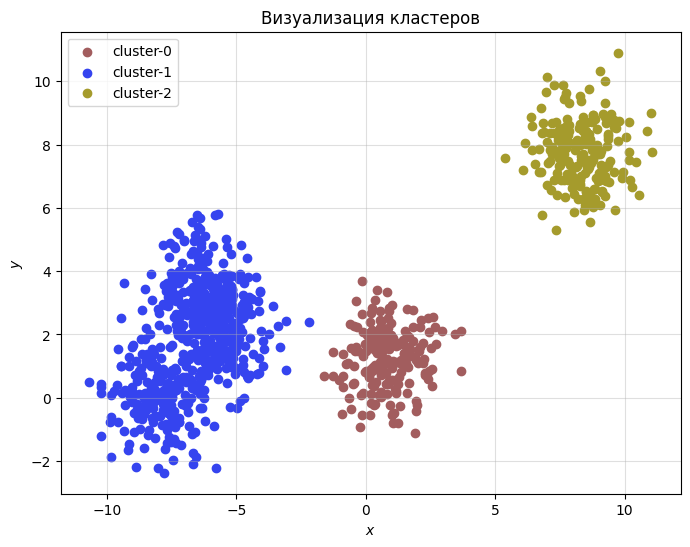

In [30]:
draw_clusters(X, model.predict(X))

### Итог

Итого, мы можем сделать вывод о том, что модели `KMeans` и `GMM` идеально
подошли для решения задачи кластеризации  для текущего датасета. Использование
модели `DBSCAN` не дало столь положительных результатов, так как модель
имеет более общее назанчение нежели другие модели и справляется с текущим
датасетом хуже.

| Модель                       | Коэффициент силуэта | Однородность | Полнота | V-мера |
|------------------------------|---------------------|--------------|---------|--------|
| DBSCAN (бейзлайн)            | 0.32                | 0.96         | 0.83    | 0.89   |
| DBSCAN (улучшенный бейзлайн) | 0.69                | 0.99         | 0.95    | 0.97   |
| KMeans                       | 0.71                | 1.00         | 1.00    | 1.00   |
| GMM                          | 0.71                | 1.00         | 1.00    | 1.00   |
